Experimented originally with creating image match
https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.134.8491&rep=rep1&type=pdf

In [1]:
import sys
sys.path.append('/Users/rsingh/Oyla/Work/our_python_dev/')
sys.path.append('/Users/rsingh/Packages/closed-form-matting//')

In [2]:
import closed_form_matting
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io

In [3]:
from oyla.mvc.utils import *
from solve_foreground_background import solve_foreground_background

In [4]:
from skimage.util import view_as_windows

In [5]:
from solve_foreground_background import solve_foreground_background

In [6]:
dir_path='/Users/rsingh/Oyla Dropbox/Oyla/02 Technical/10 Data/Oct 16 - RG visit Set 3/22_data_October_16_19_55_05/'

In [7]:
input_data_folder_name =  dir_path
csv_file = input_data_folder_name+'/parameters.csv'
parameters = read_csv_parameters(csv_file)

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [8]:
ambiguity_distance, range_max, range_min, saturation_flag, adc_flag, mod_freq, ampl_min,reflectivity_thresh = some_common_utility(parameters,0)

In [9]:
filter_params = {}
filter_parameters = {}
filter_parameters['filter_cmd'] = {}
filter_parameters = read_csv_parameters("/Users/rsingh/Oyla/Work/our_python_dev/oyla/mvc/filter_params.csv")
for k in filter_parameters['filter_cmd'].keys():
        #print(parameters['filter_cmd'][k][self.epoch_number])
        try:
                filter_params[k] = int(filter_parameters['filter_cmd'][k][0])
                #parameters['filter_cmd'][k][0] = filter_parameters['filter_cmd'][k][0]
        except ValueError:
                pass

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [10]:
filter_params['median_filter'] = 1
filter_params['edge_detection'] = 1
filter_params['edge_detection_thresholds'] = 50

In [11]:
index = np.random.randint(0,500)
#index =9
print(index)
rgb = scipy.io.loadmat(dir_path+'/data_c_'+str(index)+'.mat')

rgb = rgb['data'][0][4]

rgb = rgb_depth_view_matching(rgb)

dist = np.fromfile(dir_path+'/imageDistance_c_'+str(index)+'.bin',np.uint16())
ampl = np.fromfile(dir_path+'/imageDistance_c_'+str(index)+'_ampl.bin',np.uint16())

#dist = dist.reshape(120,320)
#ampl = ampl.reshape(120,320)

raw_phase = dist.reshape(120,320)
raw_ampl = ampl.reshape(120,320)
filtered_phase, thresholded_ampl, indices = threshold_filter(raw_phase = raw_phase, raw_ampl = raw_ampl, reflectivity_thresh= reflectivity_thresh,
                                                                             range_max = range_max, range_min = range_min, ampl_min = ampl_min,
                                                                             filter_params = filter_params, ambiguity_distance = ambiguity_distance)

170
Doing median filtering
Doing edge detection


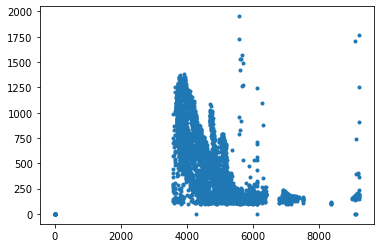

In [12]:
plt.plot(filtered_phase[raw_ampl<65000],thresholded_ampl[raw_ampl<65000],'.')

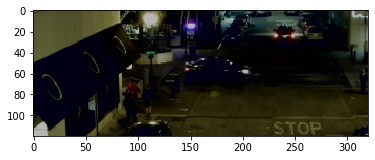

In [13]:
_rgb = cv2.resize(rgb,None,fx=120/212,fy=120/212)
_rgb = _rgb.astype('float32')/255.0
plt.imshow(_rgb)

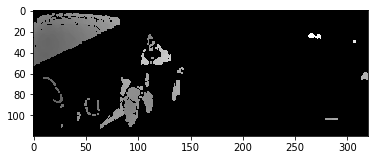

In [14]:
plt.imshow(filtered_phase,cmap='gray')

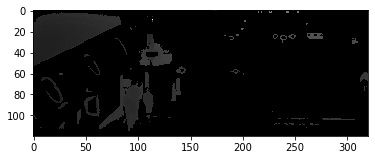

In [15]:
plt.imshow(raw_phase,cmap='gray')

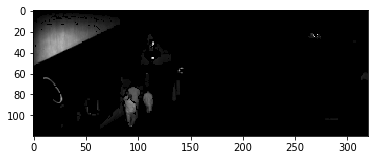

In [16]:
plt.imshow(thresholded_ampl,cmap='gray')

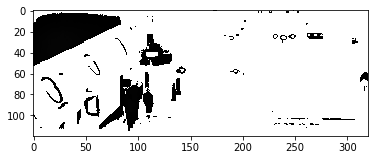

In [17]:
plt.imshow(raw_ampl,cmap='gray')

In [18]:
_hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)

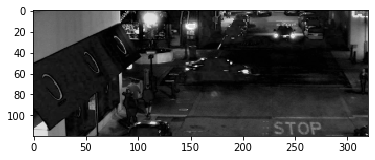

In [19]:
plt.imshow(_hsv[:,:,2],cmap='gray')

In [20]:
_lab = cv2.cvtColor(_rgb,cv2.COLOR_RGB2LAB)

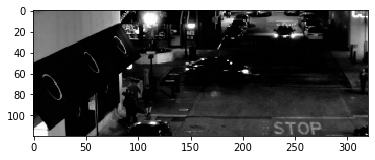

In [21]:
plt.imshow(_lab[:,:,0],cmap='gray')

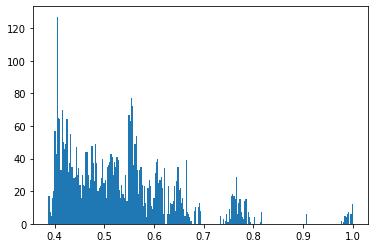

In [22]:
_=plt.hist(filtered_phase[filtered_phase>0]/np.max(filtered_phase),255)

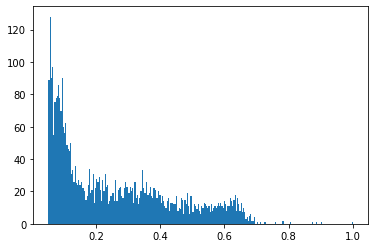

In [23]:
_=plt.hist(thresholded_ampl[thresholded_ampl>0]/np.max(thresholded_ampl),255)

In [24]:
print(np.min(filtered_phase[thresholded_ampl>0]))

3571.0


In [25]:
filtered_phase[indices['filtered_phase_beyond_range']]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [26]:
filtered_phase[(thresholded_ampl==0) &(filtered_phase>0)]

array([9146., 9146., 9173., 9215., 9122., 9101., 9079., 9079., 5627.,
       7108., 6812., 6995., 6995., 6995., 7064., 7101., 7101., 7101.,
       5848., 5848., 5848., 6121., 6315., 6315., 6121., 5862., 5555.,
       5985., 5849., 5900., 5900., 5900., 5985., 5905., 5990., 6105.,
       5871., 5063., 5063., 5967., 5207., 5140., 5135., 3571., 5210.,
       3571., 4771., 4733., 4733., 4733., 4734., 4811., 4287., 4811.,
       4811., 4798., 4734., 5551., 5689., 4843., 4839., 4805.],
      dtype=float32)

In [27]:
raw_phase[(raw_ampl>65000) &(raw_phase>0)]

array([], dtype=uint16)

In [28]:
range_min

100.0

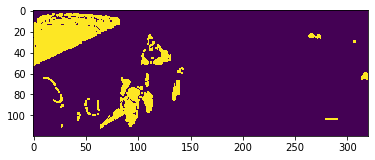

In [29]:
binary_phase = filtered_phase.copy()
binary_phase[binary_phase>0] = 1
plt.imshow(binary_phase)

62


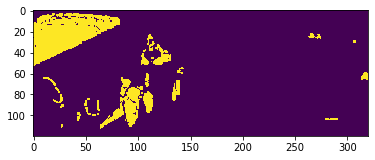

In [30]:
binary_ampl = thresholded_ampl.copy()
binary_ampl[binary_ampl>0] = 1
plt.imshow(binary_ampl)
print(np.count_nonzero(binary_ampl!=binary_phase))

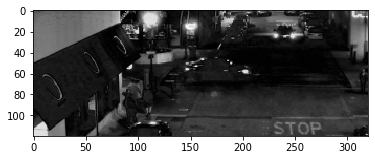

In [31]:
f = thresholded_ampl/np.max(thresholded_ampl)#filtered_phase/np.max(filtered_phase)
f[f>0] = 1
plt.imshow(_hsv[:,:,2]+f/40,cmap='gray')

In [37]:
_ehsv = _hsv.copy()
_ehsv[:,:,2]= _ehsv[:,:,2]+f*np.mean(_hsv[:,:,2])
_ehsv[:,:,2] = _ehsv[:,:,2]/np.max(_ehsv[:,:,2])

In [38]:
_ergb_hsv = cv2.cvtColor(_ehsv,cv2.COLOR_HSV2RGB)

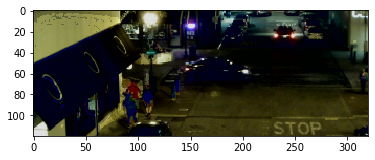

In [39]:
plt.imshow(_ergb_hsv)
plt.imsave('/Users/rsingh/Downloads/test_hsv.png',_ergb_hsv)
plt.imsave('/Users/rsingh/Downloads/test.png',_rgb)

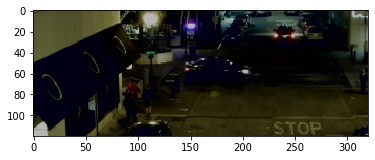

In [40]:
plt.imshow(_rgb)

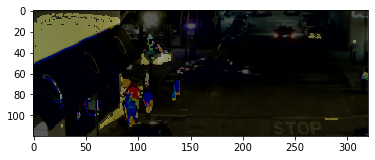

In [41]:
plt.imshow(np.abs(_ergb_hsv-_rgb)*2)

In [70]:
_elab = _lab.copy()
_elab[:,:,0]= _elab[:,:,0]+f*np.mean(_elab[:,:,0])
#_elab[:,:,0] = _elab[:,:,0]

In [71]:
_ergb_lab = cv2.cvtColor(_elab,cv2.COLOR_LAB2RGB)

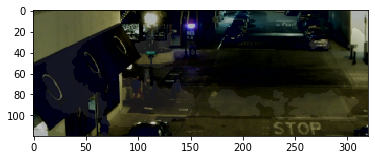

In [511]:
plt.imshow(_ergb_lab)
plt.imsave('/Users/rsingh/Downloads/test_lab.png',_ergb_lab)

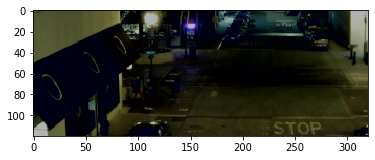

In [512]:
plt.imshow(_rgb)

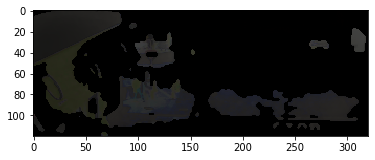

In [513]:
plt.imshow(np.abs(_ergb_lab-_rgb)*2)